In [1]:
import pandas as pd

In [3]:
#importing the dataset with the Reddit posts and their sentiments
df = pd.read_csv ('train.csv')

In [4]:
len(df)

56133

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Cashtag,Title,date,scores,compound,comp_score,just_date
0,0,0,CVE,Energy Oil &amp; Exp was the sector to be in t...,2021-04-28 20:26:09,"{'neg': 0.098, 'neu': 0.669, 'pos': 0.232, 'co...",0.7783,pos,2021-04-28
1,1,1,PLTR,$AMC AND $PLTR primed for takeoff 🚀🚀🚀,2021-04-28 20:18:57,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.9517,pos,2021-04-28
2,2,2,BUZZ,My thoughts and explanation of $BUZZ,2021-04-28 20:11:50,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
3,3,3,PLTR,$AMC and $PLTR primed for takeoff,2021-04-28 20:09:10,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
4,4,4,BLNK,GM signed agreement with $BLNK green💚💚🌎🌎🌎🌎,2021-04-28 20:05:47,"{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'comp...",0.9828,pos,2021-04-28


In [6]:
df_1 = df[['Cashtag','Title','just_date','scores','compound','comp_score']]

In [7]:
df_1[['date']] = df_1[['just_date']]
df_1.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Cashtag,Title,just_date,scores,compound,comp_score,date
0,CVE,Energy Oil &amp; Exp was the sector to be in t...,2021-04-28,"{'neg': 0.098, 'neu': 0.669, 'pos': 0.232, 'co...",0.7783,pos,2021-04-28
1,PLTR,$AMC AND $PLTR primed for takeoff 🚀🚀🚀,2021-04-28,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.9517,pos,2021-04-28
2,BUZZ,My thoughts and explanation of $BUZZ,2021-04-28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
3,PLTR,$AMC and $PLTR primed for takeoff,2021-04-28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
4,BLNK,GM signed agreement with $BLNK green💚💚🌎🌎🌎🌎,2021-04-28,"{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'comp...",0.9828,pos,2021-04-28


In [8]:
df_1.drop(['just_date'], axis=1)

,Cashtag,Title,scores,compound,comp_score,date
0,CVE,Energy Oil &amp; Exp was the sector to be in t...,"{'neg': 0.098, 'neu': 0.669, 'pos': 0.232, 'co...",0.7783,pos,2021-04-28
1,PLTR,$AMC AND $PLTR primed for takeoff 🚀🚀🚀,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.9517,pos,2021-04-28
2,BUZZ,My thoughts and explanation of $BUZZ,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
3,PLTR,$AMC and $PLTR primed for takeoff,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neut,2021-04-28
4,BLNK,GM signed agreement with $BLNK green💚💚🌎🌎🌎🌎,"{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'comp...",0.9828,pos,2021-04-28
...,...,...,...,...,...,...
56128,ZM,Whichever one of you autists executed this pla...,"{'neg': 0.123, 'neu': 0.815, 'pos': 0.062, 'co...",-0.5423,neg,2020-04-29
56129,SNDL,$SNDL buy?,"{'neg': 0.0, 'neu': 0.167, 'pos': 0.833, 'comp...",0.7184,pos,2020-04-29
56130,HEAR,CALLS ON $HEAR,"{'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...",0.7184,pos,2020-04-28
56131,HOG,Puts on $HOG,"{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'comp...",-0.7184,neg,2020-04-28


In [9]:
#grouping by date and cashtag and counting each sentiment
scores=df_1.groupby(['date','Cashtag'])['comp_score'].value_counts().to_frame()
scores.head()

comp_score
date       Cashtag comp_score            
2020-04-28 HEAR    pos                  1
           HOG     neg                  1
           LONG    neg                  1
2020-04-29 AAPL    pos                  1
           AMD     pos                  1

In [10]:
#filling nas with 0s
scores1= scores.unstack().fillna(0)
scores1.tail()

comp_score          
comp_score                neg neut  pos
date       Cashtag                     
2021-04-28 WISH           0.0  0.0  2.0
           WKHS           0.0  1.0  0.0
           WPG            0.0  0.0  1.0
           YPF            0.0  0.0  2.0
           ZKIN           0.0  0.0  1.0

In [11]:
scores2 = scores1.xs('comp_score',axis='columns')
scores2.head()

comp_score          neg  neut  pos
date       Cashtag                
2020-04-28 HEAR     0.0   0.0  1.0
           HOG      1.0   0.0  0.0
           LONG     1.0   0.0  0.0
2020-04-29 AAPL     0.0   0.0  1.0
           AMD      0.0   0.0  1.0

In [12]:
df_final=scores2.reset_index()
df_final.head()

comp_score,date,Cashtag,neg,neut,pos
0,2020-04-28,HEAR,0.0,0.0,1.0
1,2020-04-28,HOG,1.0,0.0,0.0
2,2020-04-28,LONG,1.0,0.0,0.0
3,2020-04-29,AAPL,0.0,0.0,1.0
4,2020-04-29,AMD,0.0,0.0,1.0


In [13]:
#creating total comments column
df_final['total_comments'] = df_final['pos']+df_final['neg']+df_final['neut']
df_final.head()

comp_score,date,Cashtag,neg,neut,pos,total_comments
0,2020-04-28,HEAR,0.0,0.0,1.0,1.0
1,2020-04-28,HOG,1.0,0.0,0.0,1.0
2,2020-04-28,LONG,1.0,0.0,0.0,1.0
3,2020-04-29,AAPL,0.0,0.0,1.0,1.0
4,2020-04-29,AMD,0.0,0.0,1.0,1.0


In [14]:
df_final.sort_values(by=['total_comments'], inplace=True, ascending=False)
df_final.head(5)

comp_score,date,Cashtag,neg,neut,pos,total_comments
7833,2021-01-28,GME,561.0,756.0,1598.0,2915.0
9314,2021-02-01,GME,381.0,476.0,1242.0,2099.0
9663,2021-02-02,GME,399.0,495.0,1118.0,2012.0
8397,2021-01-29,GME,256.0,416.0,859.0,1531.0
9030,2021-01-31,GME,172.0,338.0,767.0,1277.0


In [15]:
df_final.sort_values(['Cashtag','total_comments'], inplace=True, ascending=[False,False])
df_final.tail(5)

comp_score,date,Cashtag,neg,neut,pos,total_comments
10437,2021-02-08,A.T.O.S,0.0,1.0,0.0,1.0
5974,2021-01-12,A.T.A.C,0.0,1.0,0.0,1.0
5773,2021-01-07,A,0.0,0.0,1.0,1.0
5973,2021-01-12,A,0.0,0.0,1.0,1.0
6426,2021-01-20,A,1.0,0.0,0.0,1.0


##GME


In [16]:
#Webscrapping GME data
import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

In [17]:
gme = YahooFinanceHistory('GME', days_back=375).get_quote()


keep_same = {'Date'}
gme.columns = ['{}{}'.format(c, '' if c in keep_same else '_GME')
            for c in gme.columns]
gme.head()

,Date,Open_GME,High_GME,Low_GME,Close_GME,Adj Close_GME,Volume_GME
0,2020-04-29,5.83,6.09,5.45,6.04,6.04,3369600
1,2020-04-30,5.87,5.98,5.64,5.73,5.73,2173300
2,2020-05-01,5.65,6.18,5.45,6.05,6.05,4005600
3,2020-05-04,5.84,5.93,5.40,5.48,5.48,4068100
4,2020-05-05,5.55,5.63,5.35,5.39,5.39,2105900


In [18]:
#selecting only GME stocks
gme_sent = df_final[df_final['Cashtag']=='GME']
gme_sent.sort_values(by=['date'], inplace=True, ascending=False)
gme_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


comp_score,date,Cashtag,neg,neut,pos,total_comments
16576,2021-04-28,GME,0.0,3.0,5.0,8.0
16486,2021-04-27,GME,1.0,2.0,9.0,12.0
16394,2021-04-26,GME,2.0,3.0,10.0,15.0
16339,2021-04-25,GME,0.0,6.0,2.0,8.0
16302,2021-04-24,GME,0.0,3.0,0.0,3.0


In [20]:
gme['Date'] = gme['Date'].astype('str')

In [21]:
#Merging the two datafrmaes, gme stocks data and sentiment analysis
gme_merge = gme.merge(gme_sent,left_on='Date',right_on='date')
gme_merge.head()

,Date,Open_GME,High_GME,Low_GME,Close_GME,Adj Close_GME,Volume_GME,date,Cashtag,neg,neut,pos,total_comments
0,2020-05-08,4.88,5.19,4.82,4.98,4.98,2352600,2020-05-08,GME,1.0,0.0,0.0,1.0
1,2020-05-27,4.57,4.71,4.36,4.69,4.69,3146600,2020-05-27,GME,0.0,1.0,0.0,1.0
2,2020-06-08,4.28,5.14,4.27,5.01,5.01,10133700,2020-06-08,GME,0.0,0.0,1.0,1.0
3,2020-06-09,5.00,5.00,4.55,4.96,4.96,8073400,2020-06-09,GME,0.0,2.0,0.0,2.0
4,2020-08-04,4.13,4.74,4.13,4.43,4.43,10361400,2020-08-04,GME,0.0,0.0,2.0,2.0


In [22]:
import matplotlib.pyplot as plt

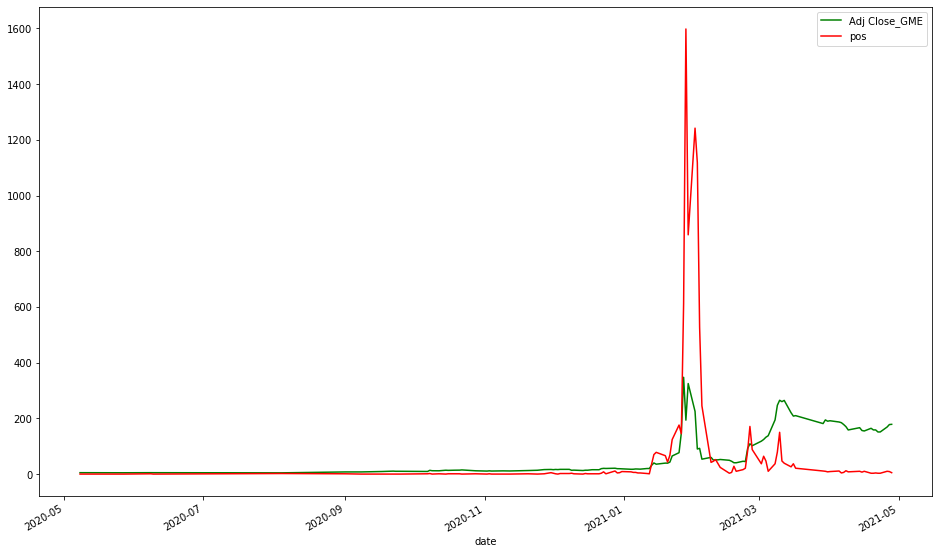

In [24]:

ax = plt.gca()

gme_merge.plot(kind='line', y='Adj Close_GME', color='green', ax=ax, figsize=(16, 10))
gme_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
gme_merge.to_csv('gme_merge.csv') 
files.download('gme_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##NOK

In [ ]:
import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd


class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.utcnow()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])


In [ ]:

nok = YahooFinanceHistory('NOK', days_back=375).get_quote()


keep_same = {'Date'}
nok.columns = ['{}{}'.format(c, '' if c in keep_same else '_NOK')
            for c in nok.columns]
nok.head()

,Date,Open_NOK,High_NOK,Low_NOK,Close_NOK,Adj Close_NOK,Volume_NOK
0,2020-04-27,3.41,3.46,3.40,3.46,3.46,12403700
1,2020-04-28,3.48,3.49,3.39,3.41,3.41,26159500
2,2020-04-29,3.49,3.55,3.42,3.51,3.51,22155600
3,2020-04-30,3.69,3.70,3.56,3.58,3.58,55906500
4,2020-05-01,3.53,3.63,3.46,3.60,3.60,32805500


In [ ]:
# nok.loc[:,'Date'] =  pd.to_datetime(nok.loc[:,'Date'], format='%Y-%m-%d')
# nok.head()


In [ ]:
nok_sent = df_final[df_final['Cashtag']=='NOK']
nok_sent.sort_values(by=['date'], inplace=True, ascending=False)
nok_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16514,2021-04-27,NOK,0.0,1.0,0.0,1.0
16412,2021-04-26,NOK,0.0,1.0,0.0,1.0
16353,2021-04-25,NOK,0.0,0.0,1.0,1.0
15983,2021-04-19,NOK,0.0,0.0,1.0,1.0
15788,2021-04-15,NOK,0.0,1.0,0.0,1.0


In [ ]:
nok['Date'] = nok['Date'].astype('str')

In [ ]:

nok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           261 non-null    object 
 1   Open_NOK       261 non-null    float64
 2   High_NOK       261 non-null    float64
 3   Low_NOK        261 non-null    float64
 4   Close_NOK      261 non-null    float64
 5   Adj Close_NOK  261 non-null    float64
 6   Volume_NOK     261 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.4+ KB


In [ ]:
nok_merge = nok.merge(nok_sent,left_on='Date',right_on='date')
nok_merge.head()

,Date,Open_NOK,High_NOK,Low_NOK,Close_NOK,Adj Close_NOK,Volume_NOK,date,Cashtag,neg,neut,pos,total_comments
0,2020-07-15,4.39,4.40,4.28,4.33,4.33,29809700,2020-07-15,NOK,0.0,0.0,1.0,1.0
1,2020-07-27,4.33,4.37,4.32,4.34,4.34,21065900,2020-07-27,NOK,1.0,0.0,0.0,1.0
2,2020-07-30,4.22,4.53,4.16,4.45,4.45,58415900,2020-07-30,NOK,0.0,0.0,1.0,1.0
3,2020-09-02,4.75,4.82,4.70,4.78,4.78,31895600,2020-09-02,NOK,0.0,0.0,1.0,1.0
4,2020-10-12,4.05,4.06,4.01,4.03,4.03,18341200,2020-10-12,NOK,0.0,1.0,0.0,1.0


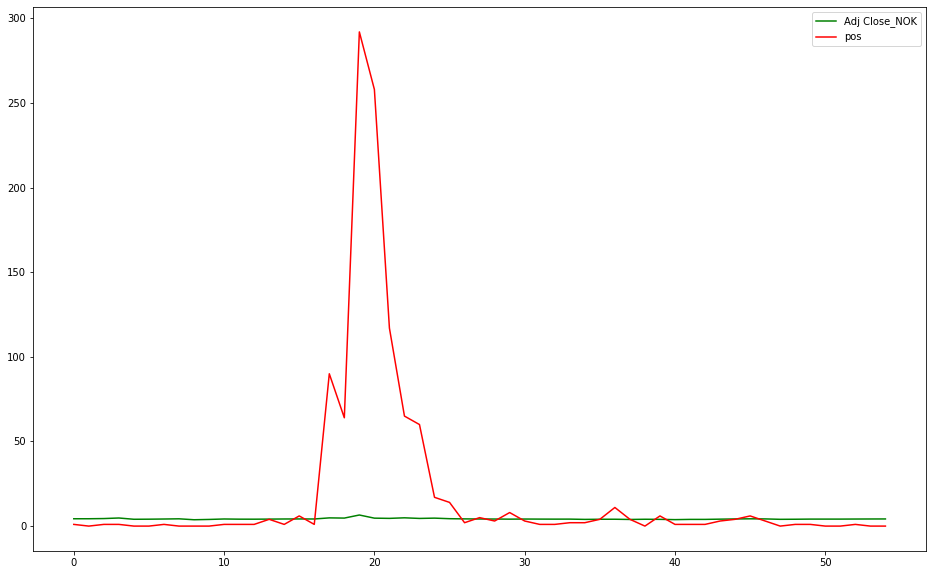

In [ ]:
# gca stands for 'get current axis'
ax = plt.gca()

nok_merge.plot(kind='line', y='Adj Close_NOK', color='green', ax=ax, figsize=(16, 10))
nok_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
nok_merge.to_csv('nok_merge.csv') 
files.download('nok_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##SNDL


In [ ]:
sndl = YahooFinanceHistory('SNDL', days_back=375).get_quote()


keep_same = {'Date'}
sndl.columns = ['{}{}'.format(c, '' if c in keep_same else '_SNDL')
            for c in sndl.columns]
sndl.head(5)

,Date,Open_SNDL,High_SNDL,Low_SNDL,Close_SNDL,Adj Close_SNDL,Volume_SNDL
0,2020-04-27,0.528,0.540,0.470,0.493,0.493,1437400
1,2020-04-28,0.502,0.525,0.480,0.495,0.495,520000
2,2020-04-29,0.496,0.500,0.490,0.499,0.499,704600
3,2020-04-30,0.505,0.590,0.451,0.570,0.570,1914500
4,2020-05-01,0.599,0.670,0.550,0.635,0.635,1284300


In [ ]:
sndl_sent = df_final[df_final['Cashtag']=='SNDL']
sndl_sent.sort_values(by=['date'], inplace=True, ascending=False)
sndl_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16534,2021-04-27,SNDL,0.0,1.0,0.0,1.0
16052,2021-04-20,SNDL,0.0,1.0,3.0,4.0
15992,2021-04-19,SNDL,0.0,3.0,3.0,6.0
15939,2021-04-18,SNDL,0.0,1.0,0.0,1.0
15805,2021-04-15,SNDL,0.0,0.0,1.0,1.0


In [ ]:
sndl['Date'] = sndl['Date'].astype('str')

In [ ]:
sndl_merge = sndl.merge(sndl_sent,left_on='Date',right_on='date')
sndl_merge.head()

,Date,Open_SNDL,High_SNDL,Low_SNDL,Close_SNDL,Adj Close_SNDL,Volume_SNDL,date,Cashtag,neg,neut,pos,total_comments
0,2020-04-29,0.496,0.500,0.490,0.499,0.499,704600,2020-04-29,SNDL,0.0,0.0,1.0,1.0
1,2020-09-30,0.200,0.257,0.196,0.241,0.241,50199500,2020-09-30,SNDL,0.0,0.0,1.0,1.0
2,2020-11-30,0.494,0.860,0.455,0.729,0.729,2037786800,2020-11-30,SNDL,0.0,1.0,2.0,3.0
3,2020-12-01,0.912,0.950,0.583,0.653,0.653,1260028700,2020-12-01,SNDL,0.0,1.0,2.0,3.0
4,2020-12-02,0.717,0.825,0.665,0.808,0.808,823299700,2020-12-02,SNDL,0.0,1.0,0.0,1.0


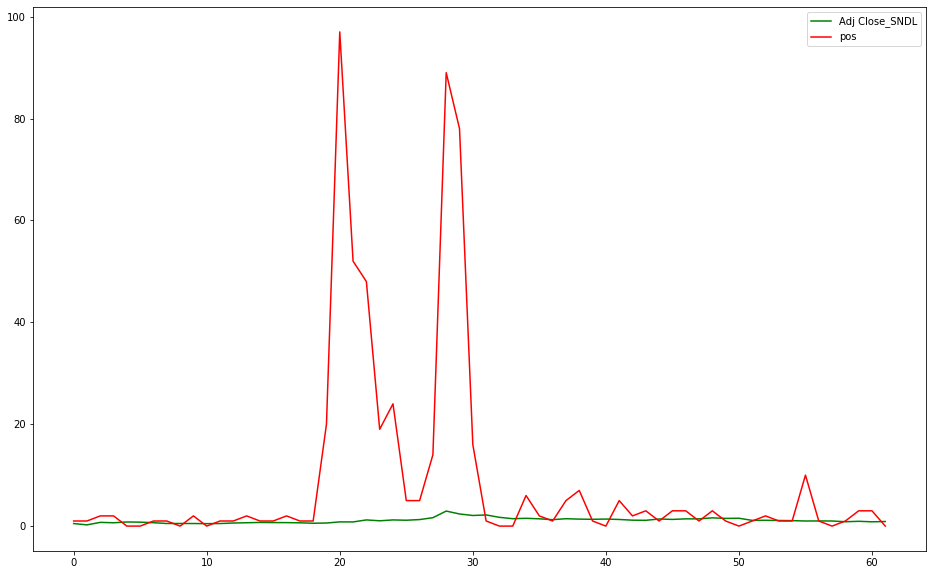

In [ ]:
ax = plt.gca()

sndl_merge.plot(kind='line', y='Adj Close_SNDL', color='green', ax=ax, figsize=(16, 10))
sndl_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
sndl_merge.to_csv('sndl_merge.csv') 
files.download('sndl_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##FSR

In [ ]:
fsr = YahooFinanceHistory('FSR', days_back=375).get_quote()


keep_same = {'Date'}
fsr.columns = ['{}{}'.format(c, '' if c in keep_same else '_FSR')
            for c in fsr.columns]
fsr.head(5)

,Date,Open_FSR,High_FSR,Low_FSR,Close_FSR,Adj Close_FSR,Volume_FSR
0,2020-04-27,10.20,10.24,10.17,10.18,10.18,256200
1,2020-04-28,10.18,10.19,10.18,10.18,10.18,1217400
2,2020-04-29,10.19,10.19,10.17,10.17,10.17,1025700
3,2020-04-30,10.17,10.18,10.17,10.17,10.17,8100
4,2020-05-01,10.17,10.20,10.16,10.16,10.16,3500


In [ ]:
fsr_sent = df_final[df_final['Cashtag']=='FSR']
fsr_sent.sort_values(by=['date'], inplace=True, ascending=False)
fsr_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16337,2021-04-25,FSR,1.0,0.0,0.0,1.0
16164,2021-04-22,FSR,0.0,1.0,1.0,2.0
15902,2021-04-17,FSR,0.0,1.0,0.0,1.0
15502,2021-04-07,FSR,0.0,0.0,1.0,1.0
15291,2021-04-03,FSR,0.0,0.0,1.0,1.0


In [ ]:
fsr['Date'] = fsr['Date'].astype('str')

In [ ]:
fsr_merge = fsr.merge(fsr_sent,left_on='Date',right_on='date')
fsr_merge.head()

,Date,Open_FSR,High_FSR,Low_FSR,Close_FSR,Adj Close_FSR,Volume_FSR,date,Cashtag,neg,neut,pos,total_comments
0,2020-10-30,9.250000,10.660000,8.90,10.140000,10.140000,21134700,2020-10-30,FSR,1.0,0.0,2.0,3.0
1,2020-11-09,11.730000,14.730000,11.05,14.340000,14.340000,38674100,2020-11-09,FSR,0.0,3.0,2.0,5.0
2,2020-11-13,16.910000,18.150000,15.87,17.440001,17.440001,34415200,2020-11-13,FSR,0.0,0.0,1.0,1.0
3,2020-11-16,18.280001,18.280001,16.35,17.100000,17.100000,16757800,2020-11-16,FSR,0.0,0.0,1.0,1.0
4,2020-11-17,16.900000,17.180000,15.67,16.430000,16.430000,14026600,2020-11-17,FSR,0.0,0.0,1.0,1.0


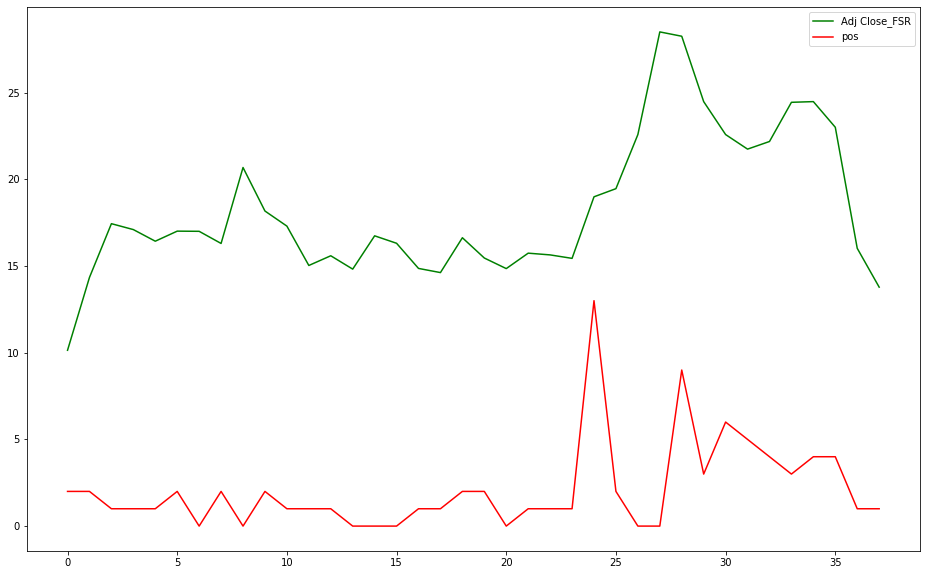

In [ ]:
ax = plt.gca()

fsr_merge.plot(kind='line', y='Adj Close_FSR', color='green', ax=ax, figsize=(16, 10))
fsr_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
fsr_merge.to_csv('fsr_merge.csv') 
files.download('fsr_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##PLTR

In [ ]:
pltr_sent = df_final[df_final['Cashtag']=='PLTR']
pltr_sent.sort_values(by=['date'], inplace=True, ascending=False)
pltr_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16607,2021-04-28,PLTR,0.0,1.0,1.0,2.0
16358,2021-04-25,PLTR,1.0,0.0,0.0,1.0
16181,2021-04-22,PLTR,0.0,1.0,0.0,1.0
15935,2021-04-18,PLTR,0.0,0.0,3.0,3.0
15907,2021-04-17,PLTR,0.0,0.0,1.0,1.0


In [ ]:
pltr['Date'] = pltr['Date'].astype('str')

In [ ]:
pltr = YahooFinanceHistory('PLTR', days_back=375).get_quote()


keep_same = {'Date'}
pltr.columns = ['{}{}'.format(c, '' if c in keep_same else '_PLTR')
            for c in pltr.columns]
pltr.head(5)

,Date,Open_PLTR,High_PLTR,Low_PLTR,Close_PLTR,Adj Close_PLTR,Volume_PLTR
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000


In [ ]:
pltr_merge = pltr.merge(pltr_sent,left_on='Date',right_on='date')
pltr_merge.head()

,Date,Open_PLTR,High_PLTR,Low_PLTR,Close_PLTR,Adj Close_PLTR,Volume_PLTR,date,Cashtag,neg,neut,pos,total_comments
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400,2020-09-30,PLTR,0.0,2.0,0.0,2.0
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600,2020-10-01,PLTR,0.0,1.0,0.0,1.0
2,2020-10-07,10.04,10.49,9.99,10.00,10.00,54672400,2020-10-07,PLTR,2.0,0.0,1.0,3.0
3,2020-10-08,10.29,10.40,9.99,10.00,10.00,34989200,2020-10-08,PLTR,0.0,0.0,2.0,2.0
4,2020-10-12,10.04,10.05,9.66,9.89,9.89,20623600,2020-10-12,PLTR,0.0,0.0,1.0,1.0


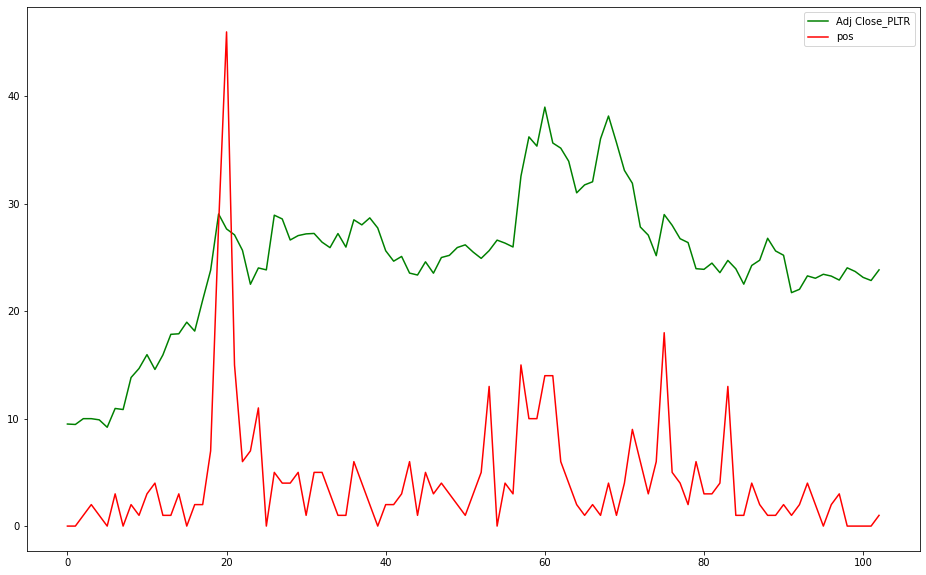

In [ ]:
ax = plt.gca()

pltr_merge.plot(kind='line', y='Adj Close_PLTR', color='green', ax=ax, figsize=(16, 10))
pltr_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
pltr_merge.to_csv('pltr_merge.csv') 
files.download('pltr_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##TRVG

In [ ]:
trvg = YahooFinanceHistory('TRVG', days_back=375).get_quote()


keep_same = {'Date'}
trvg.columns = ['{}{}'.format(c, '' if c in keep_same else '_TRVG')
            for c in trvg.columns]
trvg.head(5)

,Date,Open_TRVG,High_TRVG,Low_TRVG,Close_TRVG,Adj Close_TRVG,Volume_TRVG
0,2020-04-27,1.69,1.79,1.66,1.73,1.73,152400
1,2020-04-28,1.77,1.80,1.66,1.75,1.75,223900
2,2020-04-29,1.80,1.85,1.72,1.80,1.80,352100
3,2020-04-30,1.84,1.84,1.73,1.83,1.83,222200
4,2020-05-01,1.79,1.82,1.65,1.69,1.69,209500


In [ ]:
trvg_sent = df_final[df_final['Cashtag']=='TRVG']
trvg_sent.sort_values(by=['date'], inplace=True, ascending=False)
trvg_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
13977,2021-03-04,TRVG,0.0,1.0,0.0,1.0
13804,2021-03-03,TRVG,0.0,1.0,0.0,1.0
12285,2021-02-16,TRVG,0.0,1.0,0.0,1.0
12086,2021-02-14,TRVG,0.0,1.0,1.0,2.0
11990,2021-02-13,TRVG,0.0,0.0,3.0,3.0


In [ ]:
trvg['Date'] = trvg['Date'].astype('str')

In [ ]:

trvg_merge = trvg.merge(trvg_sent,left_on='Date',right_on='date')
trvg_merge.head()

,Date,Open_TRVG,High_TRVG,Low_TRVG,Close_TRVG,Adj Close_TRVG,Volume_TRVG,date,Cashtag,neg,neut,pos,total_comments
0,2021-01-27,2.14,5.88,2.070,3.19,3.19,43961500,2021-01-27,TRVG,0.0,1.0,1.0,2.0
1,2021-01-28,2.69,2.87,2.250,2.48,2.48,11946000,2021-01-28,TRVG,0.0,1.0,0.0,1.0
2,2021-02-01,2.63,2.74,2.310,2.38,2.38,5879000,2021-02-01,TRVG,0.0,1.0,1.0,2.0
3,2021-02-04,2.58,2.58,2.295,2.40,2.40,3412100,2021-02-04,TRVG,0.0,0.0,1.0,1.0
4,2021-02-12,2.65,3.86,2.630,3.30,3.30,24253900,2021-02-12,TRVG,0.0,3.0,8.0,11.0


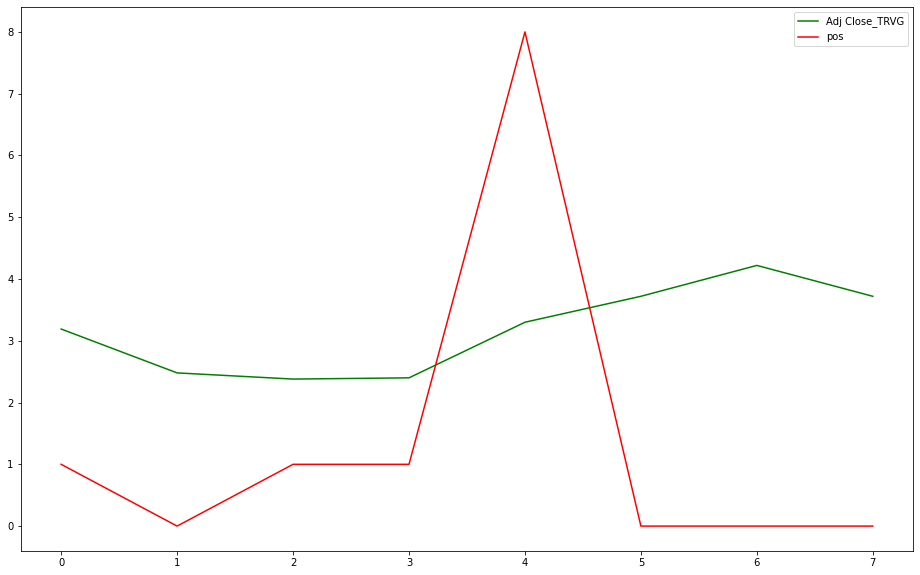

In [ ]:
ax = plt.gca()

trvg_merge.plot(kind='line', y='Adj Close_TRVG', color='green', ax=ax, figsize=(16, 10))
trvg_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
trvg_merge.to_csv('trvg_merge.csv') 
files.download('trvg_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##FIRE

In [ ]:
fire = YahooFinanceHistory('FIRE', days_back=375).get_quote()


keep_same = {'Date'}
fire.columns = ['{}{}'.format(c, '' if c in keep_same else '_FIRE')
            for c in fire.columns]
fire.head(5)

,Date,Open_FIRE,High_FIRE,Low_FIRE,Close_FIRE,Adj Close_FIRE,Volume_FIRE
0,2020-04-27,0.025,0.025,0.025,0.025,0.025,0.0
1,2020-04-28,0.025,0.025,0.025,0.025,0.025,0.0
2,2020-04-29,0.025,0.025,0.025,0.025,0.025,0.0
3,2020-04-30,0.025,0.025,0.025,0.025,0.025,0.0
4,2020-05-01,0.025,0.025,0.025,0.025,0.025,0.0


In [ ]:
fire_sent = df_final[df_final['Cashtag']=='FIRE']
fire_sent.sort_values(by=['date'], inplace=True, ascending=False)
fire_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
15644,2021-04-09,FIRE,0.0,0.0,1.0,1.0
15578,2021-04-08,FIRE,0.0,0.0,3.0,3.0
14710,2021-03-15,FIRE,0.0,0.0,1.0,1.0
13892,2021-03-04,FIRE,0.0,0.0,1.0,1.0
13469,2021-02-27,FIRE,0.0,0.0,2.0,2.0


In [ ]:
fire['Date'] = fire['Date'].astype('str')
fire_merge = fire.merge(fire_sent,left_on='Date',right_on='date')
fire_merge.head()

,Date,Open_FIRE,High_FIRE,Low_FIRE,Close_FIRE,Adj Close_FIRE,Volume_FIRE,date,Cashtag,neg,neut,pos,total_comments
0,2021-01-26,0.1300,0.1300,0.1300,0.1300,0.1300,0.0,2021-01-26,FIRE,0.0,0.0,1.0,1.0
1,2021-01-28,0.1300,0.1300,0.1300,0.1300,0.1300,0.0,2021-01-28,FIRE,0.0,0.0,1.0,1.0
2,2021-02-04,0.1300,0.1300,0.1300,0.1300,0.1300,0.0,2021-02-04,FIRE,0.0,1.0,2.0,3.0
3,2021-02-09,0.1100,0.1100,0.1070,0.1175,0.1175,64500.0,2021-02-09,FIRE,0.0,0.0,2.0,2.0
4,2021-02-10,0.1175,0.1175,0.1175,0.1175,0.1175,0.0,2021-02-10,FIRE,0.0,0.0,3.0,3.0


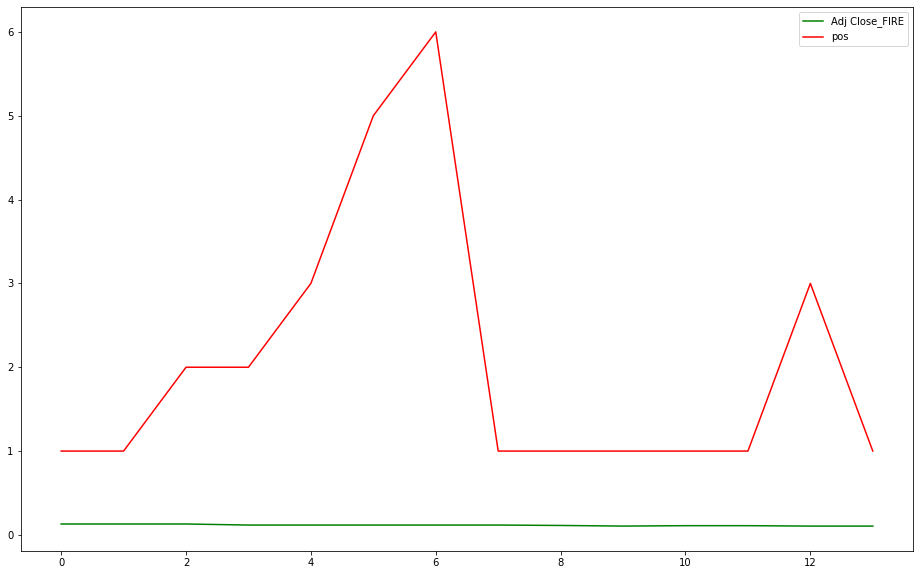

In [ ]:
ax = plt.gca()

fire_merge.plot(kind='line', y='Adj Close_FIRE', color='green', ax=ax, figsize=(16, 10))
fire_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
fire_merge.to_csv('fire_merge.csv') 
files.download('fire_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##ZOM

In [ ]:
zom = YahooFinanceHistory('ZOM', days_back=375).get_quote()


keep_same = {'Date'}
zom.columns = ['{}{}'.format(c, '' if c in keep_same else '_ZOM')
            for c in zom.columns]
zom.head(5)

,Date,Open_ZOM,High_ZOM,Low_ZOM,Close_ZOM,Adj Close_ZOM,Volume_ZOM
0,2020-04-27,0.155,0.175,0.155,0.164,0.164,29126400
1,2020-04-28,0.168,0.228,0.158,0.209,0.209,131477700
2,2020-04-29,0.190,0.200,0.176,0.180,0.180,39891200
3,2020-04-30,0.171,0.189,0.168,0.170,0.170,21085100
4,2020-05-01,0.173,0.182,0.170,0.176,0.176,9659300


In [ ]:
zom_sent = df_final[df_final['Cashtag']=='ZOM']
zom_sent.sort_values(by=['date'], inplace=True, ascending=False)
zom_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16552,2021-04-27,ZOM,0.0,0.0,1.0,1.0
16439,2021-04-26,ZOM,0.0,1.0,0.0,1.0
16210,2021-04-22,ZOM,0.0,0.0,1.0,1.0
15886,2021-04-16,ZOM,0.0,0.0,1.0,1.0
15737,2021-04-14,ZOM,0.0,0.0,2.0,2.0


In [ ]:
zom['Date'] = zom['Date'].astype('str')
zom_merge = zom.merge(zom_sent,left_on='Date',right_on='date')
zom_merge.head()

,Date,Open_ZOM,High_ZOM,Low_ZOM,Close_ZOM,Adj Close_ZOM,Volume_ZOM,date,Cashtag,neg,neut,pos,total_comments
0,2020-05-07,0.206,0.285,0.202,0.270,0.270,184427800,2020-05-07,ZOM,0.0,0.0,1.0,1.0
1,2020-05-21,0.240,0.246,0.216,0.223,0.223,25863400,2020-05-21,ZOM,0.0,0.0,1.0,1.0
2,2020-06-25,0.198,0.248,0.196,0.232,0.232,244042000,2020-06-25,ZOM,0.0,1.0,0.0,1.0
3,2020-06-26,0.245,0.275,0.220,0.243,0.243,221887600,2020-06-26,ZOM,0.0,0.0,1.0,1.0
4,2020-12-31,0.243,0.268,0.230,0.231,0.231,126322100,2020-12-31,ZOM,0.0,0.0,1.0,1.0


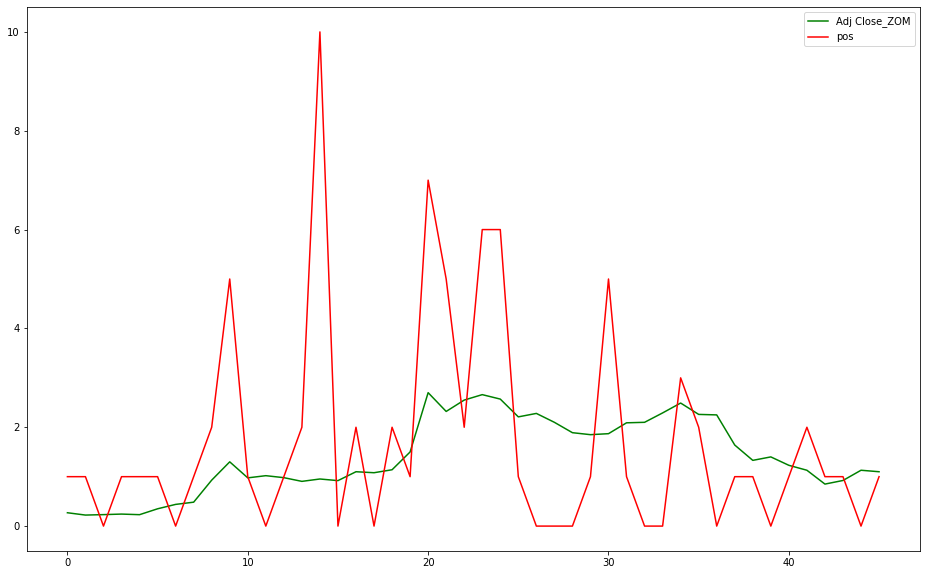

In [ ]:
ax = plt.gca()

zom_merge.plot(kind='line', y='Adj Close_ZOM', color='green', ax=ax, figsize=(16, 10))
zom_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
zom_merge.to_csv('zom_merge.csv') 
files.download('zom_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##CCIV

In [ ]:
cciv = YahooFinanceHistory('CCIV', days_back=375).get_quote()


keep_same = {'Date'}
cciv.columns = ['{}{}'.format(c, '' if c in keep_same else '_CCIV')
            for c in cciv.columns]
cciv.head(5)

,Date,Open_CCIV,High_CCIV,Low_CCIV,Close_CCIV,Adj Close_CCIV,Volume_CCIV
0,2020-09-18,10.25,10.250,9.82,9.89,9.89,564300
1,2020-09-21,9.90,9.960,9.86,9.86,9.86,762800
2,2020-09-22,9.96,9.960,9.85,9.88,9.88,1280800
3,2020-09-23,9.90,9.905,9.79,9.85,9.85,192600
4,2020-09-24,9.85,9.850,9.75,9.77,9.77,605500


In [ ]:
cciv_sent = df_final[df_final['Cashtag']=='CCIV']
cciv_sent.sort_values(by=['date'], inplace=True, ascending=False)
cciv_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
16461,2021-04-27,CCIV,0.0,0.0,3.0,3.0
16085,2021-04-21,CCIV,0.0,1.0,0.0,1.0
15950,2021-04-19,CCIV,0.0,1.0,0.0,1.0
15893,2021-04-17,CCIV,0.0,1.0,0.0,1.0
15832,2021-04-16,CCIV,1.0,0.0,0.0,1.0


In [ ]:
cciv['Date'] = cciv['Date'].astype('str')
cciv_merge = cciv.merge(cciv_sent,left_on='Date',right_on='date')
cciv_merge.head()

,Date,Open_CCIV,High_CCIV,Low_CCIV,Close_CCIV,Adj Close_CCIV,Volume_CCIV,date,Cashtag,neg,neut,pos,total_comments
0,2021-01-11,10.050000,14.000000,10.030000,13.200000,13.200000,108167500,2021-01-11,CCIV,1.0,1.0,7.0,9.0
1,2021-01-12,14.990000,15.630000,13.000000,14.150000,14.150000,111360100,2021-01-12,CCIV,1.0,3.0,3.0,7.0
2,2021-01-13,15.100000,17.120001,14.500000,16.719999,16.719999,94091500,2021-01-13,CCIV,0.0,1.0,5.0,6.0
3,2021-01-14,18.709999,20.139999,16.100000,17.360001,17.360001,140983000,2021-01-14,CCIV,1.0,1.0,1.0,3.0
4,2021-01-15,17.809999,21.000000,16.200001,18.360001,18.360001,184854200,2021-01-15,CCIV,2.0,4.0,3.0,9.0


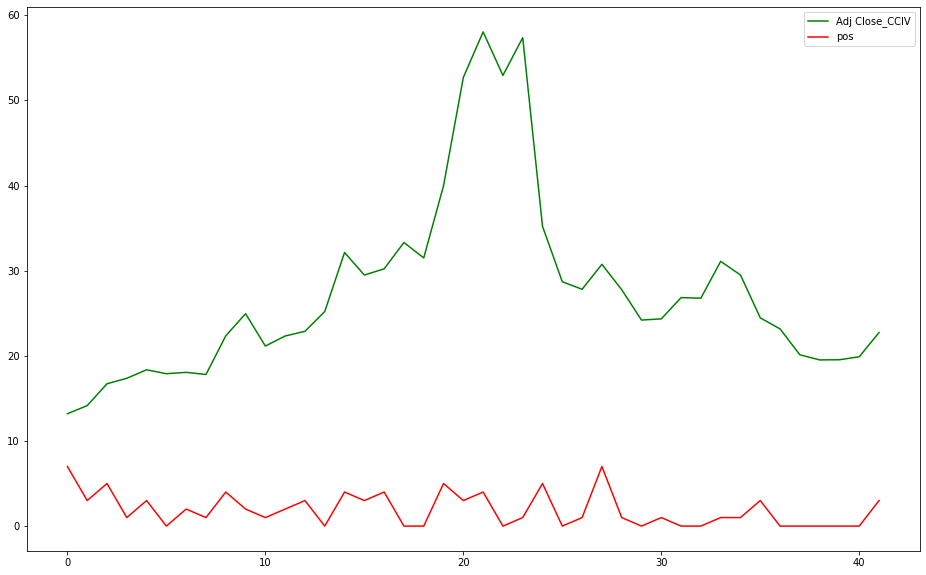

In [ ]:
ax = plt.gca()

cciv_merge.plot(kind='line', y='Adj Close_CCIV', color='green', ax=ax, figsize=(16, 10))
cciv_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
cciv_merge.to_csv('cciv_merge.csv') 
files.download('cciv_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##EBON

In [ ]:
ebon = YahooFinanceHistory('EBON', days_back=375).get_quote()


keep_same = {'Date'}
ebon.columns = ['{}{}'.format(c, '' if c in keep_same else '_EBON')
            for c in ebon.columns]
ebon.head(5)

,Date,Open_EBON,High_EBON,Low_EBON,Close_EBON,Adj Close_EBON,Volume_EBON
0,2020-06-26,4.60,5.23,3.81,5.00,5.00,694100
1,2020-06-29,4.28,4.50,4.05,4.50,4.50,212500
2,2020-06-30,4.23,4.80,4.20,4.73,4.73,213700
3,2020-07-01,4.77,4.77,3.80,3.97,3.97,154300
4,2020-07-02,4.45,5.20,4.15,4.37,4.37,755300


In [ ]:
ebon_sent = df_final[df_final['Cashtag']=='EBON']
ebon_sent.sort_values(by=['date'], inplace=True, ascending=False)
ebon_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
15899,2021-04-17,EBON,0.0,1.0,0.0,1.0
15842,2021-04-16,EBON,0.0,1.0,0.0,1.0
15766,2021-04-15,EBON,0.0,1.0,1.0,2.0
15643,2021-04-09,EBON,0.0,0.0,1.0,1.0
15576,2021-04-08,EBON,1.0,1.0,1.0,3.0


In [ ]:
ebon_sent = df_final[df_final['Cashtag']=='TRVG']
ebon_sent.sort_values(by=['date'], inplace=True, ascending=False)
ebon_sent.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


comp_score,date,Cashtag,neg,neut,pos,total_comments
13977,2021-03-04,TRVG,0.0,1.0,0.0,1.0
13804,2021-03-03,TRVG,0.0,1.0,0.0,1.0
12285,2021-02-16,TRVG,0.0,1.0,0.0,1.0
12086,2021-02-14,TRVG,0.0,1.0,1.0,2.0
11990,2021-02-13,TRVG,0.0,0.0,3.0,3.0


In [ ]:
ebon['Date'] = ebon['Date'].astype('str')
ebon_merge = ebon.merge(ebon_sent,left_on='Date',right_on='date')
ebon_merge.head()

,Date,Open_EBON,High_EBON,Low_EBON,Close_EBON,Adj Close_EBON,Volume_EBON,date,Cashtag,neg,neut,pos,total_comments
0,2021-01-27,4.460,4.94,4.42,4.54,4.54,3822900,2021-01-27,TRVG,0.0,1.0,1.0,2.0
1,2021-01-28,4.600,5.45,4.60,5.22,5.22,7271900,2021-01-28,TRVG,0.0,1.0,0.0,1.0
2,2021-02-01,5.011,5.38,4.72,5.05,5.05,2870300,2021-02-01,TRVG,0.0,1.0,1.0,2.0
3,2021-02-04,6.070,6.27,5.52,6.26,6.26,13948500,2021-02-04,TRVG,0.0,0.0,1.0,1.0
4,2021-02-12,5.680,6.80,5.62,6.69,6.69,26122700,2021-02-12,TRVG,0.0,3.0,8.0,11.0


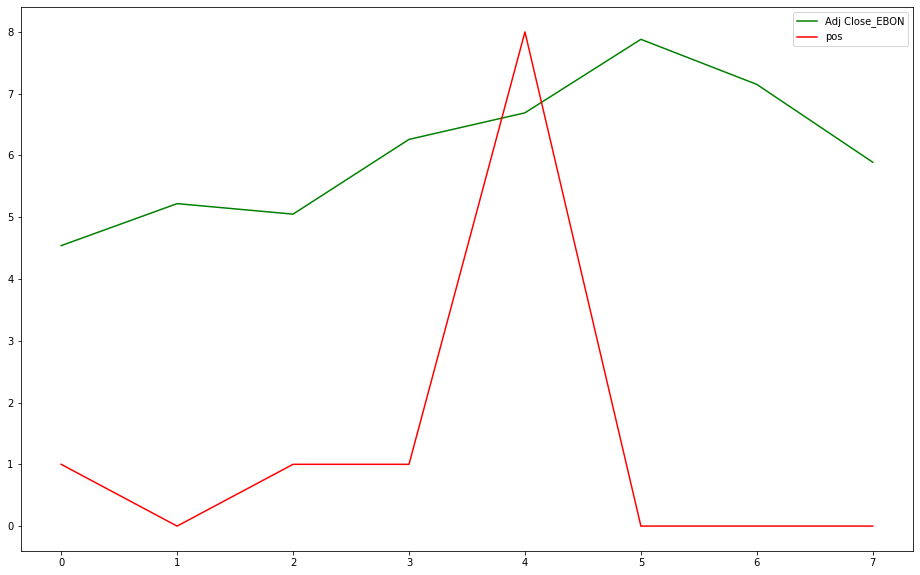

In [ ]:
ax = plt.gca()

ebon_merge.plot(kind='line', y='Adj Close_EBON', color='green', ax=ax, figsize=(16, 10))
ebon_merge.plot(kind='line', y='pos', color='red', ax=ax, figsize=(16, 10))

plt.show()

In [ ]:
from google.colab import files
ebon_merge.to_csv('ebon_merge.csv') 
files.download('ebon_merge.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ebon_merge.head()

,Date,Open_EBON,High_EBON,Low_EBON,Close_EBON,Adj Close_EBON,Volume_EBON,date,Cashtag,neg,neut,pos,total_comments
0,2021-01-27,4.460,4.94,4.42,4.54,4.54,3822900,2021-01-27,TRVG,0.0,1.0,1.0,2.0
1,2021-01-28,4.600,5.45,4.60,5.22,5.22,7271900,2021-01-28,TRVG,0.0,1.0,0.0,1.0
2,2021-02-01,5.011,5.38,4.72,5.05,5.05,2870300,2021-02-01,TRVG,0.0,1.0,1.0,2.0
3,2021-02-04,6.070,6.27,5.52,6.26,6.26,13948500,2021-02-04,TRVG,0.0,0.0,1.0,1.0
4,2021-02-12,5.680,6.80,5.62,6.69,6.69,26122700,2021-02-12,TRVG,0.0,3.0,8.0,11.0


In [ ]:
df_merged = pd.concat([gme_merge, ebon_merge, cciv_merge, zom_merge, pltr_merge, fsr_merge, sndl_merge, nok], ignore_index=True)

In [ ]:
from google.colab import files
df_merged.to_csv('df_merged.csv') 
files.download('df_merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>